# Task2 - Bangla Handwritten Digit Recognition

### Importing necessary packages like CNTK, numpy etc

In [1]:
import os
from keras.models import model_from_json
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Activation
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
import numpy as np

/home/bishwa/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Load Data from local directory

In [2]:
def get_data(filename, num_samples, local_data_dir):
        # Read data.
        f=open(filename, "r")
        res = np.fromstring(f.read(num_samples * 28 * 28), dtype = np.uint8)
        return res.reshape((num_samples, 28 * 28))

def get_labels(filename, num_samples, local_data_dir):
        # Read labels.
        f=open(filename, "r")
        res = np.fromstring(f.read(num_samples), dtype = np.uint8)
        return res.reshape((num_samples, 1))

In [3]:
def load_data(data_filename, labels_filename, number_samples, local_data_dir=None):
    data = get_data(data_filename, number_samples, local_data_dir)
    labels = get_labels(labels_filename, number_samples, local_data_dir)
    return np.hstack((data, labels))

### Save the data files into a format compatible with CNTK text reader

In [4]:
def save_as_txt(filename, ndarray):
    dir = os.path.dirname(filename)

    if not os.path.exists(dir):
        os.makedirs(dir)

    if not os.path.isfile(filename):
        print("Saving to ", filename, " ")
        with open(filename, 'w') as f:
            labels = list(map(' '.join, np.eye(10, dtype=np.uint).astype(str)))
            for row in ndarray:
                row_str = row.astype(str)
                label_str = labels[row[-1]]
                feature_str = ' '.join(row_str[:-1])
                f.write('|labels {} |features {}\n'.format(label_str, feature_str))
    else:
        print("File already exists", filename)

### Retrieve and process the training and testing data

In [5]:
# Ensure we always get the same amount of randomness
np.random.seed(0)

# Define the data dimensions
image_shape = (1, 28, 28)
input_dim = int(np.prod(image_shape, dtype=int))
output_dim = 10

num_train_samples = 23824
num_test_samples = 2653
X_train = np.loadtxt("train_images.txt")
y_train = np.loadtxt("train_labels.txt")
X_test = np.loadtxt("test_images.txt")
y_test = np.loadtxt("test_labels.txt")
# The local path where the training and test data might be found or will be downloaded to.
training_data_path = os.path.join(os.getcwd(), "bangla_digit_dataset", "Train.txt")
testing_data_path = os.path.join(os.getcwd(), "bangla_digit_dataset", "Test.txt")

### Data Testing

In [6]:
feature_stream_name = 'features'
labels_stream_name = 'labels'
print(y_train.shape)    # Only labels
print(X_train.shape)    # Data

(23824,)
(23824, 784)


In [7]:
from keras.utils import np_utils

In [8]:
# We have (n, width, height) but we need (n, depth, width, height)
# where n is the number of entries
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
# Normalize so that value is between 0 and 1
X_train /= 255
X_test /= 255

#Categorize the labels
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)

## Constructing the Convolutional Neural Network
### ConvNet architectures:
####  1 Convolutional Layer
####   2 Pooling Layer
####   3 Fully-Connected Layer(Dense)

In [9]:
# Now we will define out NN
model = Sequential() # First layer initiated


### Convultional Layer ###

In [10]:
# 8 Convulution filters
# (3 rows and 3 cols for each convultion filter)
# Relu activation: will return = if value is below 0 and raw input if above
# An input with 1 depth (channels), 28 widht and 28 height
model.add(Conv2D(8, (3, 3), activation='relu', input_shape=(28,28,1)))
model.add(Conv2D(8, (3, 3), activation='relu'))   # Add another layer

### Pooling Layer ###

In [11]:
# To reduce the parameters, it will take the maximum of the 4 values (2x2)
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))  # To avoid overfitting

### Fully-Connected Layer (Dense)#######

In [12]:
####### Fully-Connected Layer #######
# The weights from the Convolution layers must be flattened (made 1-dimensional)
# before passing them to the fully connected Dense layer.
model.add(Flatten())
model.add(Dense(128, activation='relu'))    # output of 120
model.add(Dropout(0.2))
# Softmax allow us to convert inputs to values between 0 and 1. The sum of them will be 1
model.add(Dense(10, activation='softmax'))  # output of 10 (final layer!!!)

## Compile the model


In [22]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## Train the model

In [14]:
# batch_size: Fom training dataset how many entries use each time
# nb_epoch: Neural networks are trained iteratively,
#   making multiple passes over entire dataset.
#   Each pass over entire dataset is referred to as epoch.
model.fit(X_train, Y_train, batch_size=64, epochs=5, verbose=1)

Epoch 1/5
23824/23824 [==============================] - 15s 627us/step - loss: 0.4272 - acc: 0.8614
Epoch 2/5
23824/23824 [==============================] - 15s 615us/step - loss: 0.1392 - acc: 0.9565
Epoch 3/5
23824/23824 [==============================] - 15s 616us/step - loss: 0.0945 - acc: 0.9695
Epoch 4/5
23824/23824 [==============================] - 15s 614us/step - loss: 0.0682 - acc: 0.9786
Epoch 5/5
23824/23824 [==============================] - 15s 624us/step - loss: 0.0565 - acc: 0.9809


## Visualization

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [16]:
#confusion matrix 

y_pred = model.predict_classes(X_test) # This will take a few seconds...
y_true = np_utils.to_categorical(y_test)

target_names = ["0", "1", "2","3","4","5","6","7","8","9"]

# Compute a confusion matrix and a normalised confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_normalised = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# These can also be used to produce heatmaps using Matplotlib or Seaborn.
print(cm)

[[258   1   0   0   0   0   0   0   0   0]
 [  0 271   3   0   0   0   0   0   0   3]
 [  0   0 243   0   0   0   0   1   0   1]
 [  2   0   0 254   0   0   2   1   0   2]
 [  0   1   1   0 280   0   0   0   0   1]
 [  1   0   2   0   0 273   4   1   0   0]
 [  0   0   0   3   0   1 252   0   0   1]
 [  0   0   0   0   1   0   0 268   0   0]
 [  0   0   0   0   0   1   4   0 251   0]
 [  0   8   0   0   0   0   0   0   0 257]]


[Text(1039.6,0.5,u'True label'), Text(0.5,64,u'Predicted label')]

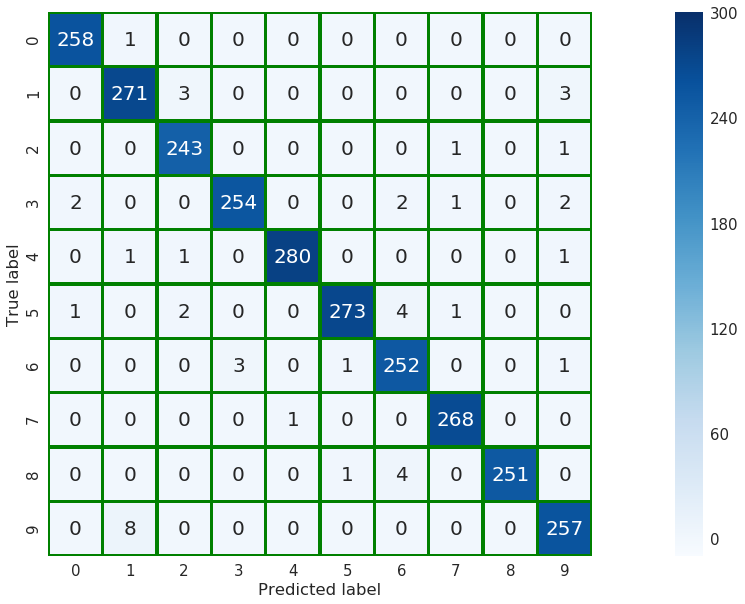

In [17]:
# Plot a confusion matrix graphically 
sns.set(font_scale=1.5) 
fig, ax = plt.subplots(figsize=(30,10))
ax = sns.heatmap(cm, annot=True, linewidths=2.5, square=True, linecolor="Green", 
                    cmap="Blues", yticklabels=target_names, xticklabels=target_names, vmin=-10, vmax=300, 
                    fmt="d", annot_kws={"size": 20})
ax.set(xlabel='Predicted label', ylabel='True label')

### Evaluation

In [18]:
score = model.evaluate(X_test, Y_test, verbose=0)
#evaluates loss value and accuracy metric
print("Score: {}".format(score))

Score: [0.05515775284521026, 0.9826611381317596]


In [21]:
## Save Model
##   REF: https://machinelearningmastery.com/save-load-keras-deep-learning-models/

model.save_weights("model.weights")
with open("model.json", "w") as json_file:
    model_json = model.to_json()
    json_file.write(model_json)

### Testing Phase

#### to be continued...
